In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("input"))


import cv2
import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Activation, Input, BatchNormalization, ZeroPadding2D, Dropout
from keras.models import Sequential, Model

['cell_images']


In [3]:
base = 'input/cell_images/'
para = os.listdir(base+'Parasitized')
nor = os.listdir(base+'Uninfected')

In [4]:
len(para), len(nor)

(13780, 13780)

In [5]:
#This function takes image as input and returns the RGB image of the same read image
#The image is also resized into smaller shape and Dimension of 110x110.

def image_reader(path):
    t=cv2.imread(path)
    t=cv2.cvtColor(t, cv2.COLOR_BGR2RGB)
    t=cv2.resize(t, (110,110))
    return t

In [6]:
X = []
Y = [] 

for x in para:
    # Parasite variable 
    try:
        t = image_reader(base+'Parasitized/'+x)
        X.append(t)
        Y.append(1)
    except:
        pass
    
for x in nor:
    # Non Parasite images variable
    try:
        t = image_reader(base+'Uninfected/'+x)
        X.append(t)
        Y.append(0)
    except:
        pass

In [7]:
X=np.array(X)
Y=np.array(Y)
Y_oh = keras.utils.to_categorical(Y, num_classes=2)
print(X.shape, Y_oh.shape)

(27558, 110, 110, 3) (27558, 2)


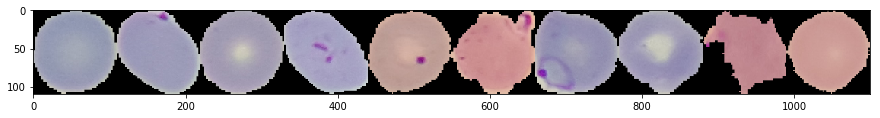

In [8]:
# Show training images
np.random.seed(10)

concat_img = None
for i in range(10):
    idx = np.random.randint(X.shape[0])
    if concat_img is None:
        concat_img = X[idx]
    else:
        concat_img = np.concatenate([concat_img, X[idx]], axis=1)
plt.figure(figsize=(15, 5)) 
plt.imshow(concat_img)


In [9]:
train_x, test_x, train_y, test_y = train_test_split(X,Y_oh,test_size=0.1, shuffle=True)

In [10]:
X_input = Input((110,110,3))

# Zero-Padding: pads the border of X_input with zeroes
X = ZeroPadding2D((3, 3))(X_input)

# CONV -> BN -> RELU Block applied to X
X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)

# MORE CONVS
X = MaxPooling2D((2, 2))(X)
#shortcut = X
X = Conv2D(32, (3, 3), strides = (1, 1), padding="same")(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(32, (3, 3), strides = (1, 1), padding="same")(X)
X = BatchNormalization()(X)
#X = layers.add([X, shortcut])
X = Activation('relu')(X)

# MAXPOOL
X = MaxPooling2D((2, 2), name='max_pool')(X)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = Flatten()(X)

# MORE DENSE
X = Dense(128)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)

X = Dense(2, activation='softmax', name='fc')(X)

# Create model. This creates Keras model instance, use this instance to train/test the model.
model = Model(inputs = X_input, outputs = X, name='HappyModel')

In [11]:
model.compile('SGD', 'categorical_crossentropy', ['acc'])

In [12]:
history = model.fit(train_x, train_y, validation_split=0.1, epochs=5, batch_size=128)

Train on 22321 samples, validate on 2481 samples
Epoch 1/5
22321/22321 [==============================] - 1791s 80ms/step - loss: 0.5742 - acc: 0.7321 - val_loss: 1.3099 - val_acc: 0.5119
Epoch 2/5
22321/22321 [==============================] - 1735s 78ms/step - loss: 0.2375 - acc: 0.9132 - val_loss: 0.6871 - val_acc: 0.6780
Epoch 3/5
22321/22321 [==============================] - 1773s 79ms/step - loss: 0.1823 - acc: 0.9361 - val_loss: 0.1941 - val_acc: 0.9383
Epoch 4/5
22321/22321 [==============================] - 1884s 84ms/step - loss: 0.1500 - acc: 0.9496 - val_loss: 0.3820 - val_acc: 0.8166
Epoch 5/5
22321/22321 [==============================] - 1785s 80ms/step - loss: 0.1385 - acc: 0.9514 - val_loss: 0.2233 - val_acc: 0.9327


In [13]:
model.evaluate(test_x, test_y)

2756/2756 [==============================] - 77s 28ms/step


[0.21106439932683382, 0.9390420913696289]

0 0


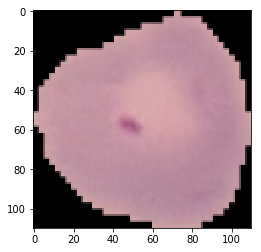

In [14]:
idx=124
t = test_x[idx].reshape(1,110, 110, 3)
print(np.argmax(test_y[idx]), np.argmax(model.predict(t)))
plt.imshow(t[0])